In [6]:
# ! pip install tensorflow keras opencv-python Pillow

In [7]:
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights, maskrcnn_resnet50_fpn
# import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
# from sklearn.model_selection import train_test_split

In [8]:
annotations_df_original = pd.read_csv('./annotations0.csv')

In [9]:
annotations_df_original["label_name"].value_counts()

label_name
measuring_object                     279
color_palate                         224
info_tag                             169
id_tag                               128
color_palate_and_measuring_object     98
miscellaneous                         50
Name: count, dtype: int64

In [10]:
# drop the rows with label_name = "info_tag"
annotations_df = annotations_df_original.drop(annotations_df_original[annotations_df_original["label_name"] == "miscellaneous"].index)

In [11]:
# annotations_df.drop(annotations_df[annotations_df["label_name"] == "info_tag"].index, inplace=True)

In [12]:
annotations_df["label_name"].value_counts()

label_name
measuring_object                     279
color_palate                         224
info_tag                             169
id_tag                               128
color_palate_and_measuring_object     98
Name: count, dtype: int64

In [13]:
len(list(annotations_df["image_name"].unique()))

396

In [14]:
def apply_gaussian_blur_and_edge_detection(image):
    # Convert PIL Image to numpy array
    image_np = np.array(image)
    
    #Modify the contrast and brightness of the image
    image_np = cv2.convertScaleAbs(image_np, alpha=1.1, beta=-100)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image_np, (5,5), sigmaX=10)

    blurred_pil = Image.fromarray(blurred)

    # Convert to grayscale
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)

    gray_pil = Image.fromarray(gray)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, threshold1=10, threshold2=95, L2gradient=True)

    # Morbitize the edges. Kind of like filling the gaps in the edges
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Convert single channel image to 3 channels
    edges_3channel = np.stack((closing,)*3, axis=-1)

    # Dilate edges
    dilated_edges = cv2.dilate(edges_3channel, kernel=None, iterations=1)

    # Convert numpy array back to PIL Image
    edges_pil = Image.fromarray(dilated_edges)

    enhanced_image = cv2.addWeighted(image_np, 1, dilated_edges, 0.5, 0)

    enhanced_image_pil = Image.fromarray(enhanced_image)
    
    return enhanced_image_pil

In [15]:
# To make sure that the lamda function is serializable
class ImageAugmentation(object):
    def __call__(self, x):
        return apply_gaussian_blur_and_edge_detection(x)

In [16]:
class_to_idx = {class_name: i for i, class_name in enumerate(annotations_df['label_name'].unique())}

In [17]:
idx_to_class = {i: class_name for class_name, i in class_to_idx.items()}

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
def get_model_instance_segmentation(num_classes):
    
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Now get the number of input features for the mask predictor and replace the mask head with a new one
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [20]:
model = get_model_instance_segmentation(len(class_to_idx) + 1)

In [21]:
model = model.to(device)

In [22]:
# Loading a pre-existing trained model parameters
model_state_dict = torch.load('model_weights.pth', map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [23]:
def get_transform():
    return Compose([
        ImageAugmentation(),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [28]:
image_path = './bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation/0b9190a636268e0e.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Convert to PIL for compatibility with torchvision transforms
image_pil = Image.fromarray(image)

# Apply the same transformations as during training
transformations = get_transform()
transformed_img = transformations(image_pil)

# Add batch dimension
transformed_img = transformed_img.to(device)

In [29]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradients needed
    prediction = model([transformed_img])

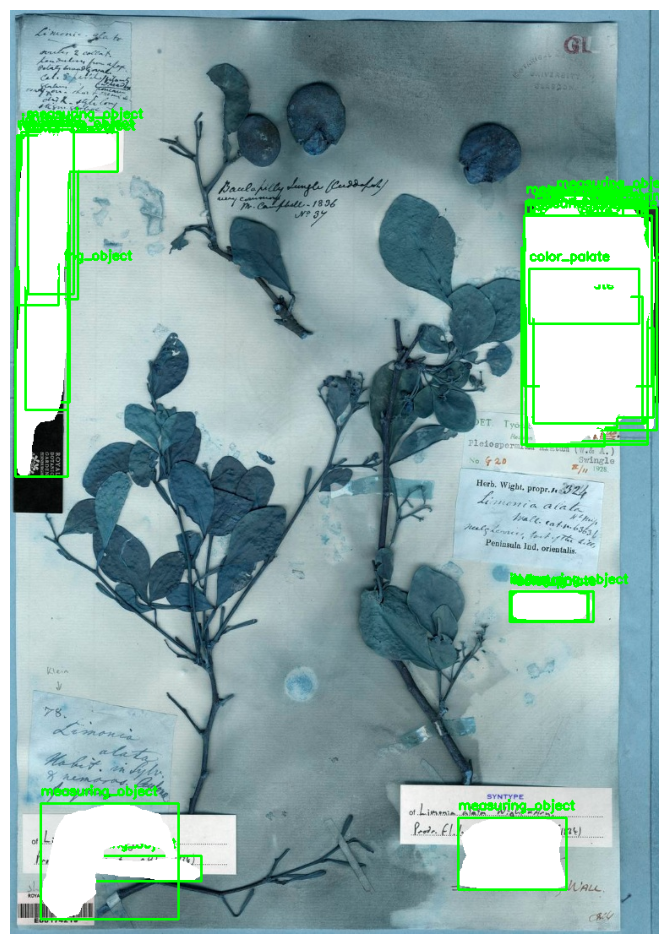

In [31]:
# Initialize an overlay that will accumulate all masks
overlay = np.copy(image)

# Convert from BGR (OpenCV default) to RGB for Matplotlib
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Threshold and process each mask
threshold = 0.9 # play around with this value to get better results
for i, (mask, label) in enumerate(zip(prediction[0]['masks'], prediction[0]['labels'])):
    # Apply threshold to convert the probability mask to a binary mask
    binary_mask = mask[0] > threshold
    
    # Convert binary mask to a NumPy array
    mask_np = binary_mask.cpu().numpy().astype(np.uint8)
    
    # Make mask pixels white in the overlay
    overlay[mask_np == 1] = [255, 255, 255]
    
    # Optionally, find contours and draw the class label next to the object
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Draw bounding box and class name near the first contour
        contour = contours[0]
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(overlay, idx_to_class[label.item()], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)

# Using Matplotlib to display the final image with all masks and class labels applied
plt.figure(figsize=(12, 12))
plt.imshow(overlay)
plt.axis('off')  # Hide axis
plt.show()
